# Regridding data

In [1]:
import cartopy.crs as ccrs
import libs.helpers as helpers
import matplotlib
import matplotlib.pyplot as plt
import xesmf
import xarray

import warnings
warnings.filterwarnings('ignore')


def regrid_latlon(data, method='bilinear', extrap_method=None):
    latlon_grid = xesmf.util.grid_global(1.875, 1.25)
    regridder = xesmf.Regridder(data, latlon_grid, method=method, extrap_method=extrap_method)

    return regridder(data)


def regrid_latlon_nsidc(i, o, mode='bilinear'):
    data = xarray.open_mfdataset(paths=i, combine='by_coords')
    data_latlon = regrid_latlon(data, mode)

    mask = data_latlon.mask.where(data_latlon.mask > 5).where(data_latlon.mask < 16)
    data_latlon['mask'] = mask

    o_edited = o.replace('.nc', f'_{mode}.nc')
    data_latlon.to_netcdf(o_edited)

    return o_edited


def plot_regridded_data(data, title='', x='lon', y='lat'):
    transform = ccrs.PlateCarree()
    fig, ax = plt.subplots(
        1, 
        1,
        figsize=(10, 10),
        subplot_kw={ 
            'projection': ccrs.Stereographic(central_latitude=90.0)
        }
    )
    fig.suptitle(title)
    ax.coastlines(resolution='110m', linewidth=0.5)
    ax.set_extent([-180, 180, 50, 90], transform)
    gl = ax.gridlines()
    gl.ylocator = matplotlib.ticker.LinearLocator(4)
    data.plot.pcolormesh(
        ax=ax,
        x=x, 
        y=y,
        transform=transform
    )

## NSIDC Regions

In [2]:
path = '_data/NSIDC_Regions_Masks.nc'
o = '_data/_cache/NSIDC_Regions_Masks_LatLon.nc'

o_bilinear = regrid_latlon_nsidc(path, o)
o_nearest_s2d = regrid_latlon_nsidc(path, o, mode='nearest_s2d')

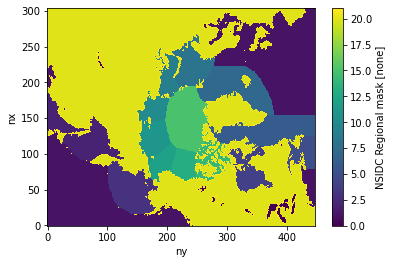

In [3]:
xarray.open_mfdataset(paths='_data/NSIDC_Regions_Masks.nc', combine='by_coords').mask.plot()

In [ ]:
plot_regridded_data(xarray.open_mfdataset(paths=o_bilinear, combine='by_coords').mask, title='bilinear')
plot_regridded_data(xarray.open_mfdataset(paths=o_nearest_s2d, combine='by_coords').mask, title='nearest_s2d')

## Sea-ice/ocean grid

In [ ]:
siconc_base = helpers.get_data('ssp585', 'SImon', 'siconc', 'r2i1p1f2')
siconca_base = helpers.get_data('ssp585', 'SImon', 'siconca', 'r2i1p1f2')

siconc = siconc_base.siconc[0, :, :]
siconca = siconca_base.siconca[0, :, :]

siconc_latlon = regrid_latlon(siconc_base).siconc[0, :, :]
siconc_latlon_ext = regrid_latlon(siconc_base, extrap_method='nearest_s2d').siconc[0, :, :]
siconc_latlon_s2d = regrid_latlon(siconc_base, 'nearest_s2d').siconc[0, :, :]

In [ ]:
plot_regridded_data(siconc, title='original (ocean grid)', x='longitude', y='latitude')
plot_regridded_data(siconca, title='original (atmos grid)')
plot_regridded_data(siconc_latlon, title='bilinear')
plot_regridded_data(siconc_latlon_ext, title='bilinear with extrapolation nearest_s2d')
plot_regridded_data(siconc_latlon_s2d, title='nearest_s2d')

In [ ]:
path_areacella = '_data/cmip6/UKESM1/areacella_fx_UKESM1-0-LL_piControl_r1i1p1f2_gn.nc'
areacella = xarray.open_mfdataset(paths=path_areacella, combine='by_coords').areacella

path_areacello = '_data/cmip6/UKESM1/areacello_Ofx_UKESM1-0-LL_piControl_r1i1p1f2_gn.nc'
areacello = xarray.open_mfdataset(paths=path_areacello, combine='by_coords').areacello

siconc = siconc.where(siconc.latitude > 60)
siconca = siconca.where(siconca.lat > 60)
siconc_latlon = siconc_latlon.where(siconc_latlon.lat > 60)
siconc_latlon_ext = siconc_latlon_ext.where(siconc_latlon_ext.lat > 60)
siconc_latlon_s2d = siconc_latlon_s2d.where(siconc_latlon_s2d.lat > 60)

area_o = (siconc * areacello).sum(dim=('i', 'j'), skipna=True).values
area_a = (siconca * areacella).sum(dim=('lat', 'lon'), skipna=True).values
area_bil = (siconc_latlon.values * areacella).sum(dim=('lat', 'lon'), skipna=True).values * 1.
area_ext = (siconc_latlon_ext.values * areacella).sum(dim=('lat', 'lon'), skipna=True).values * 1.
area_s2d = (siconc_latlon_s2d.values * areacella).sum(dim=('lat', 'lon'), skipna=True).values * 1.

In [ ]:
print('siconc (ocean grid):')
print(f'-> area: {area_o}')

print('\nsiconca (atmosphere grid):')
print(f'-> area: {area_a}')
print(f'-> siconc diff: {round(100 * (area_a - area_o)/area_o, 4)}%')

print('\nbilinear:')
print(f'-> area: {area_bil}')
print(f'-> siconc diff: {round(100 * (area_bil - area_o)/area_o, 4)}%')

print('\nbilinear with extrapolation nearest_s2d:')
print(f'-> area: {area_ext}')
print(f'-> siconc diff: {round(100 * (area_ext - area_o)/area_o, 4)}%')

print('\ns2d:')
print(f'-> area: {area_s2d}')
print(f'-> siconc diff: {round(100 * (area_s2d - area_o)/area_o, 4)}%')